# <p style="padding:15px; background-color:grey; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">1. Import Packages</p>

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import xgboost as xgb


# <p style="padding:15px; background-color:grey; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">2. Load Data</p>

In [2]:
consumption_df = pd.read_csv('data/OE_HP_Consumption.csv')

In [3]:
consumption_df.head()

,interval_start,heat_pump_id,consumption_kwh
0,2024-01-01 00:00:00+00:00,1001,0.37
1,2024-01-01 00:00:00+00:00,1031,NaN
2,2024-01-01 00:00:00+00:00,1038,0.07
3,2024-01-01 00:00:00+00:00,1046,0.64
4,2024-01-01 00:00:00+00:00,1002,0.22


In [4]:
temperature_df = pd.read_csv('data/OE_HP_Temperature.csv')

In [5]:
temperature_df.head()

,interval_start,location_id,external_temperature_c
0,2024-01-01 00:00:00+0000,101,3.10
1,2024-01-01 00:00:00+0000,102,3.70
2,2024-01-01 00:00:00+0000,103,5.46
3,2024-01-01 00:00:00+0000,104,5.68
4,2024-01-01 00:00:00+0000,105,3.79


In [6]:
property_df = pd.read_csv('data/OE_HP_Property_Metadata.csv')

In [7]:
property_df.head()

,heat_pump_id,property_type,floor_area_m2,number_of_bedrooms,decade_built,insulation_level,has_hot_water_storage,location_id
0,1001,bungalow,98,2,2010,excellent,True,128
1,1002,terraced,81,2,1970,poor,True,127
2,1003,detached,188,3,2020,excellent,True,108
3,1004,flat,68,2,1970,poor,False,119
4,1005,bungalow,127,2,2020,good,True,109


# <p style="padding:15px; background-color:grey; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3. Data Cleaning & Exploratory Data Analysis (EDA)</p>

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3.1 Consumption</p>

In [8]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878400 entries, 0 to 878399
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   interval_start   878400 non-null  object 
 1   heat_pump_id     878400 non-null  int64  
 2   consumption_kwh  874086 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.1+ MB


In [9]:
# Let's convert 'date' column to datetime format without timezone
consumption_df['interval_start'] = pd.to_datetime(consumption_df['interval_start']).dt.tz_localize(None)

In [10]:
consumption_df.head()

,interval_start,heat_pump_id,consumption_kwh
0,2024-01-01,1001,0.37
1,2024-01-01,1031,NaN
2,2024-01-01,1038,0.07
3,2024-01-01,1046,0.64
4,2024-01-01,1002,0.22


In [11]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878400 entries, 0 to 878399
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   interval_start   878400 non-null  datetime64[ns]
 1   heat_pump_id     878400 non-null  int64         
 2   consumption_kwh  874086 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 20.1 MB


In [12]:
consumption_df.describe().T

,count,mean,min,25%,50%,75%,max,std
interval_start,878400,2024-07-01 23:45:00,2024-01-01 00:00:00,2024-04-01 11:52:30,2024-07-01 23:45:00,2024-10-01 11:37:30,2024-12-31 23:30:00,NaN
heat_pump_id,878400.0,1025.5,1001.0,1013.0,1025.5,1038.0,1050.0,14.430878
consumption_kwh,874086.0,0.219093,0.0,0.07,0.14,0.27,14.04,0.261324


In [13]:
# Let's identify missing values in the dataset
consumption_df.isnull().sum()

interval_start        0
heat_pump_id          0
consumption_kwh    4314
dtype: int64

In [14]:
# Instead of deleting the entire rows with empty values, let's replace missing 'consumption_kwh' 
# with the mean of the previous value and the next one by using linear interpolation between two known values.
consumption_df['consumption_kwh'] = consumption_df.groupby('heat_pump_id')['consumption_kwh'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both'))


In [15]:
# Check if there are still any missing values
consumption_df.isnull().sum()

interval_start     0
heat_pump_id       0
consumption_kwh    0
dtype: int64

In [16]:
# To validate the interpolation, we can print the consumption values before and after the interpolation for heat_pump_ID=1031
consumption_df[consumption_df['heat_pump_id'] == 1002][['interval_start', 'consumption_kwh']].head(10)

,interval_start,consumption_kwh
4,2024-01-01 00:00:00,0.22
54,2024-01-01 00:30:00,0.21
104,2024-01-01 01:00:00,0.22
154,2024-01-01 01:30:00,0.21
204,2024-01-01 02:00:00,0.22
254,2024-01-01 02:30:00,0.22
304,2024-01-01 03:00:00,0.24
354,2024-01-01 03:30:00,0.22
404,2024-01-01 04:00:00,0.20
454,2024-01-01 04:30:00,0.25


Before the interpolation, consumption data @row 354, 3:30am was missing. Now it contains a value which is the average between the previous and the next consumption data. 
The linear interpolation works fine!

In [17]:
# Let's determine the unique heat pump IDs in the consumption dataset and count them
heat_pump_ids_unique = consumption_df['heat_pump_id'].unique()
print(heat_pump_ids_unique)
total_unique = len(heat_pump_ids_unique)
print('Total number of heat pumps:', total_unique)

[1001 1031 1038 1046 1002 1048 1003 1012 1022 1004 1039 1005 1018 1023
 1036 1040 1006 1029 1047 1007 1042 1008 1009 1010 1026 1011 1013 1014
 1019 1041 1015 1016 1020 1017 1021 1043 1049 1024 1027 1045 1025 1028
 1044 1030 1032 1033 1035 1034 1037 1050]
Total number of heat pumps: 50


In [18]:
consumption_df.head()

,interval_start,heat_pump_id,consumption_kwh
0,2024-01-01,1001,0.37
1,2024-01-01,1031,0.07
2,2024-01-01,1038,0.07
3,2024-01-01,1046,0.64
4,2024-01-01,1002,0.22


(0.0, 2.0)

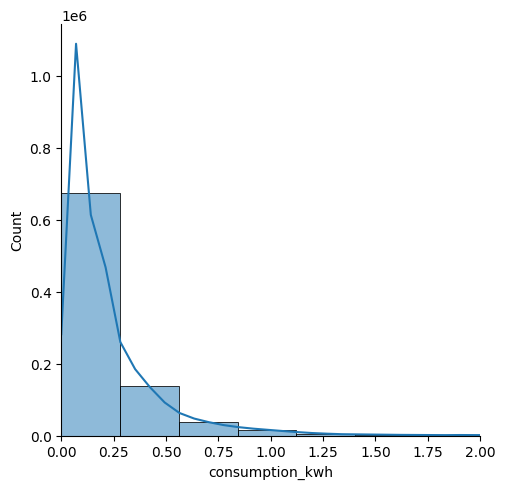

In [19]:
# Let's plot the distribution of consumption values
sns.displot(consumption_df['consumption_kwh'], bins=50, kde=True)
plt.xlim(0, 2)

The distribution of the consumption is skewed to the left, with a long tail on the right side. This indicates that most of the time, the consumption is low, but there are occasional spikes in consumption.

<Axes: title={'center': 'Consumption Outliers'}>

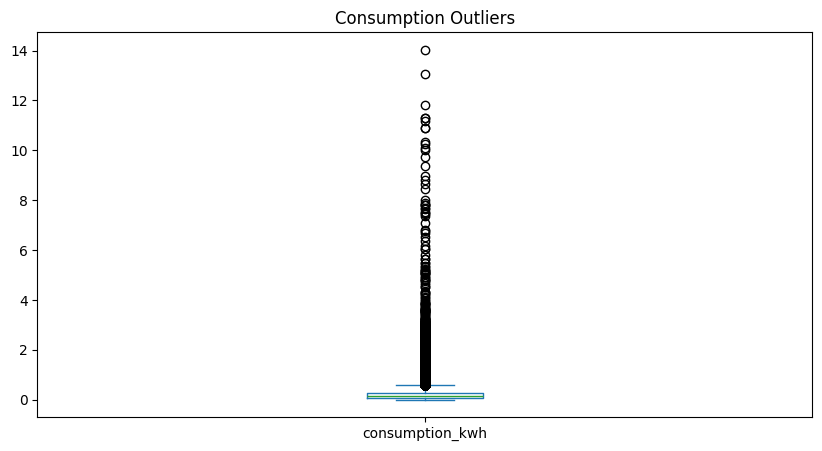

In [20]:
# Let's find out outliers in the consumption data
consumption_df['consumption_kwh'].plot(kind='box', figsize=(10, 5), title='Consumption Outliers')

It's difficult to assess the outliers in the consumption dataset as the data reflect the consumption across multiple type of properties and in multiple locations.
It would be more informative to look at the consumption data for each property type separately later in the notebook.

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3.2 Temperature</p>

In [21]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   interval_start          527040 non-null  object 
 1   location_id             527040 non-null  int64  
 2   external_temperature_c  527040 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.1+ MB


In [22]:
# Let's determine the unique location_id in the temperature dataset and count them
location_id_unique = temperature_df['location_id'].unique()
print(location_id_unique)
total_unique = len(location_id_unique)
print('Total location_id:',total_unique)

[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130]
Total location_id: 30


In [23]:
# Let's convert 'date' column to datetime format without timezone
temperature_df['interval_start'] = pd.to_datetime(temperature_df['interval_start']).dt.tz_localize(None)

In [24]:
temperature_df.head()

,interval_start,location_id,external_temperature_c
0,2024-01-01,101,3.10
1,2024-01-01,102,3.70
2,2024-01-01,103,5.46
3,2024-01-01,104,5.68
4,2024-01-01,105,3.79


In [25]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   interval_start          527040 non-null  datetime64[ns]
 1   location_id             527040 non-null  int64         
 2   external_temperature_c  527040 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.1 MB


In [26]:
# Let's identify missing values in the dataset
temperature_df.isnull().sum()

interval_start            0
location_id               0
external_temperature_c    0
dtype: int64

In [27]:
temperature_df.describe().T

,count,mean,min,25%,50%,75%,max,std
interval_start,527040,2024-07-01 23:45:00,2024-01-01 00:00:00,2024-04-01 11:52:30,2024-07-01 23:45:00,2024-10-01 11:37:30,2024-12-31 23:30:00,NaN
location_id,527040.0,115.5,101.0,108.0,115.5,123.0,130.0,8.65545
external_temperature_c,527040.0,10.206082,-3.29,5.02,10.2,15.39,23.4,6.132544


<Axes: title={'center': 'Temperature Outliers'}>

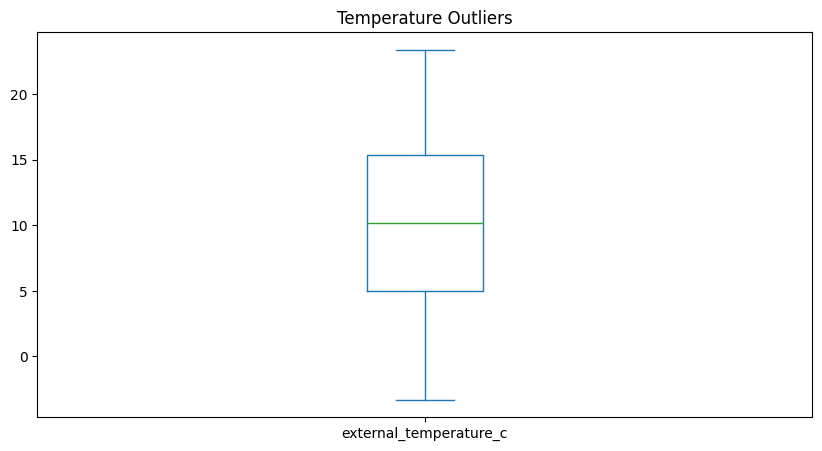

In [28]:
# Let's find out outliers in the temperature data
temperature_df['external_temperature_c'].plot(kind='box', figsize=(10, 5), title='Temperature Outliers')

It looks like that the temperature dataset doesn't have any outliers.

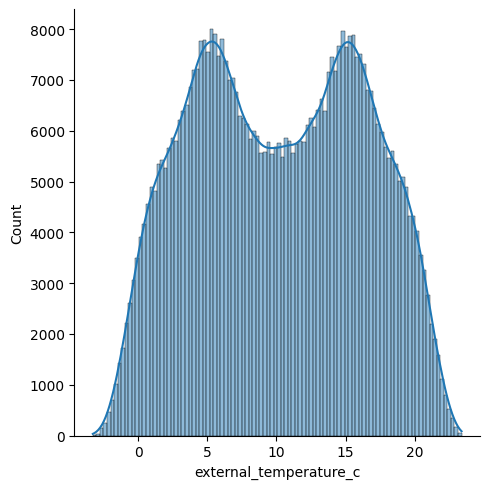

In [29]:
sns.displot(temperature_df['external_temperature_c'], kde=True)

The distribution of temperature is not normal (Gaussian) but describes a bimodal distribution, with two local maximum (peaks) at around 5 and 16 degrees Celsius, and a local minimum at around 10 degrees Celsius. 
This suggests that there are two distinct temperature regimes in the data, possibly corresponding to different seasons or weather patterns.

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3.3 Property</p>

In [30]:
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   heat_pump_id           50 non-null     int64 
 1   property_type          50 non-null     object
 2   floor_area_m2          50 non-null     int64 
 3   number_of_bedrooms     50 non-null     int64 
 4   decade_built           50 non-null     int64 
 5   insulation_level       50 non-null     object
 6   has_hot_water_storage  50 non-null     bool  
 7   location_id            50 non-null     int64 
dtypes: bool(1), int64(5), object(2)
memory usage: 2.9+ KB


In [31]:
# Let's verify that the unique heat pump IDs in the property dataset is the same as in the consumption dataset
set(property_df['heat_pump_id']) == set(consumption_df['heat_pump_id'])


True

In [32]:
# Let's validate the unique location_id in the property dataset is the same as in the temperature dataset
location_id_unique = property_df['location_id'].unique()
print(location_id_unique)
total_unique = len(location_id_unique)
print(total_unique)

[128 127 108 119 109 101 110 104 102 123 129 125 121 122 103 114 130 124
 118 117 126 120 106 112 105]
25


The location_ids in property dataset are a subset of the location_id in temperature dataset.
This is expected, as the property dataset contains information about the properties that are located in the areas where the temperature data was collected.
This will be useful later when we will merge the property data with the temperature data to create a single dataset that contains all the information we need for our analysis.

In [33]:
property_df.describe().T

,count,mean,std,min,25%,50%,75%,max
heat_pump_id,50.0,1025.50,14.577380,1001.0,1013.25,1025.5,1037.75,1050.0
floor_area_m2,50.0,119.00,68.623195,44.0,75.25,105.0,123.00,298.0
number_of_bedrooms,50.0,2.50,0.931315,1.0,2.00,2.5,3.00,5.0
decade_built,50.0,1985.40,32.839125,1930.0,1970.00,1990.0,2010.00,2020.0
location_id,50.0,116.16,9.491908,101.0,108.25,117.5,124.00,130.0


In [34]:
# Let's identify missing values in the dataset
property_df.isnull().sum()

heat_pump_id             0
property_type            0
floor_area_m2            0
number_of_bedrooms       0
decade_built             0
insulation_level         0
has_hot_water_storage    0
location_id              0
dtype: int64

In [35]:
property_df.head()

,heat_pump_id,property_type,floor_area_m2,number_of_bedrooms,decade_built,insulation_level,has_hot_water_storage,location_id
0,1001,bungalow,98,2,2010,excellent,True,128
1,1002,terraced,81,2,1970,poor,True,127
2,1003,detached,188,3,2020,excellent,True,108
3,1004,flat,68,2,1970,poor,False,119
4,1005,bungalow,127,2,2020,good,True,109


In [37]:
# Let's find out the total of type of properties we have
property_types = property_df['property_type'].value_counts()
print(property_types)

property_type
flat             15
terraced         13
detached          9
bungalow          8
semi-detached     5
Name: count, dtype: int64


# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3.4 How does heat pump consumption vary by temperature?</p>

To assess the relationship between heat pump consumption and temperature, we can plot the average heat pump consumption for each temperature value.
To perform this analysis we will merge the heat pump consumption dataset with the temperature dataset on the common column interval_start, and then group the dataset by temperature to calculate the average consumption for each temperature value. 

In [38]:
consumption_df

,interval_start,heat_pump_id,consumption_kwh
0,2024-01-01 00:00:00,1001,0.37
1,2024-01-01 00:00:00,1031,0.07
2,2024-01-01 00:00:00,1038,0.07
3,2024-01-01 00:00:00,1046,0.64
4,2024-01-01 00:00:00,1002,0.22
...,...,...,...
878395,2024-12-31 23:30:00,1033,0.93
878396,2024-12-31 23:30:00,1035,0.05
878397,2024-12-31 23:30:00,1034,0.06
878398,2024-12-31 23:30:00,1037,0.05


In [39]:
temperature_df

,interval_start,location_id,external_temperature_c
0,2024-01-01 00:00:00,101,3.10
1,2024-01-01 00:00:00,102,3.70
2,2024-01-01 00:00:00,103,5.46
3,2024-01-01 00:00:00,104,5.68
4,2024-01-01 00:00:00,105,3.79
...,...,...,...
527035,2024-12-31 23:30:00,126,4.07
527036,2024-12-31 23:30:00,127,4.87
527037,2024-12-31 23:30:00,128,7.40
527038,2024-12-31 23:30:00,129,6.26


In [40]:
# Let's merge the consumption and temperature DataFrames on 'interval_start'
consumption_temp_merged_df = pd.merge(consumption_df, temperature_df, on=['interval_start'], how='left')

In [41]:
consumption_temp_merged_df.head()

,interval_start,heat_pump_id,consumption_kwh,location_id,external_temperature_c
0,2024-01-01,1001,0.37,101,3.10
1,2024-01-01,1001,0.37,102,3.70
2,2024-01-01,1001,0.37,103,5.46
3,2024-01-01,1001,0.37,104,5.68
4,2024-01-01,1001,0.37,105,3.79


In [42]:
# Let's verify that the unique heat pump IDs in the combined DataFrame match those in the consumption DataFrame
set(consumption_temp_merged_df['heat_pump_id']) == set(consumption_df['heat_pump_id'])


True

In [43]:
# Let's aggregate each consumption data to daily average consumption
daily_consumption_df = consumption_temp_merged_df.groupby(['heat_pump_id', pd.Grouper(key='interval_start', freq='D')])['consumption_kwh'].mean().reset_index()
daily_consumption_df

,heat_pump_id,interval_start,consumption_kwh
0,1001,2024-01-01,0.164583
1,1001,2024-01-02,0.149583
2,1001,2024-01-03,0.158125
3,1001,2024-01-04,0.186250
4,1001,2024-01-05,0.172917
...,...,...,...
18295,1050,2024-12-27,1.025104
18296,1050,2024-12-28,1.024375
18297,1050,2024-12-29,1.021042
18298,1050,2024-12-30,1.025208


In [44]:
# Let's aggregate each temperature data to daily average temperature
daily_temperature_df = consumption_temp_merged_df.groupby(['heat_pump_id', pd.Grouper(key='interval_start', freq='D')])['external_temperature_c'].mean().reset_index()
daily_temperature_df


,heat_pump_id,interval_start,external_temperature_c
0,1001,2024-01-01,2.296354
1,1001,2024-01-02,2.292021
2,1001,2024-01-03,2.275875
3,1001,2024-01-04,2.239764
4,1001,2024-01-05,2.253535
...,...,...,...
18295,1050,2024-12-27,2.384937
18296,1050,2024-12-28,2.354000
18297,1050,2024-12-29,2.342000
18298,1050,2024-12-30,2.309111


In [45]:
# Let's merge the daily consumption and temperature data
consumption_temp_merged_df = pd.merge(daily_consumption_df, daily_temperature_df, on=['heat_pump_id', 'interval_start'], how='left')
# Rename columns for clarity
consumption_temp_merged_df.rename(columns={'consumption_kwh': 'daily_average_consumption_kwh', 'external_temperature_c': 'daily_average_temperature_c'}, inplace=True)
consumption_temp_merged_df.head()

,heat_pump_id,interval_start,daily_average_consumption_kwh,daily_average_temperature_c
0,1001,2024-01-01,0.164583,2.296354
1,1001,2024-01-02,0.149583,2.292021
2,1001,2024-01-03,0.158125,2.275875
3,1001,2024-01-04,0.186250,2.239764
4,1001,2024-01-05,0.172917,2.253535


/var/folders/l1/j74c0f2s2273qr62tb9_bv1w0000gn/T/ipykernel_30053/3375004031.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


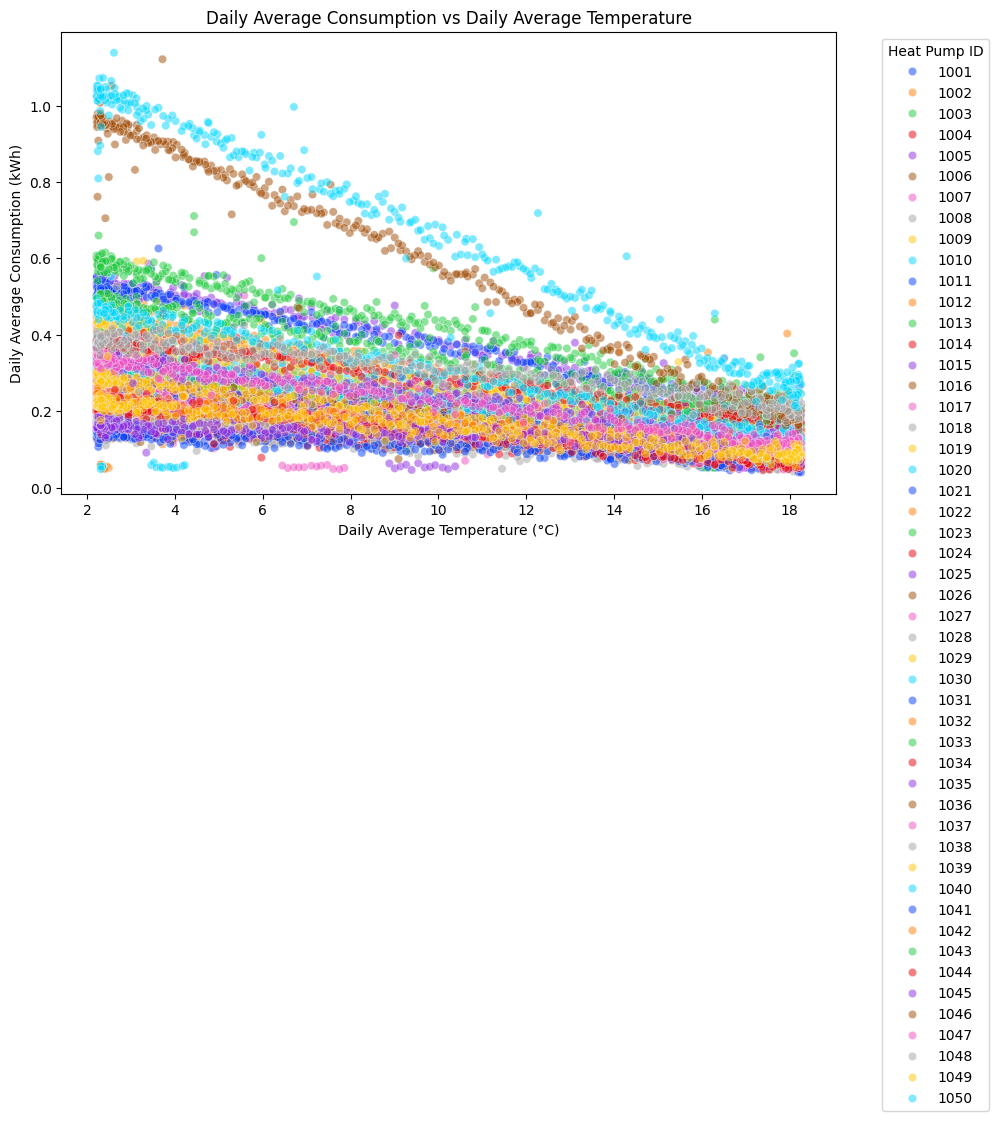

In [46]:
# Let's plot the daily average consumption against the average daily temperature      
plt.figure(figsize=(10, 6))
sns.scatterplot(data=consumption_temp_merged_df, x='daily_average_temperature_c', y='daily_average_consumption_kwh', hue='heat_pump_id', alpha=0.5, legend='full', palette='bright')    
plt.title('Daily Average Consumption vs Daily Average Temperature')
plt.xlabel('Daily Average Temperature (°C)')
plt.ylabel('Daily Average Consumption (kWh)')
plt.legend(title='Heat Pump ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This scatter plot suggests a strong negative correlation between the heat pump consumption and temperature across all the properties.
This suggests that as the temperature increases, the heat pump consumption decreases, which is expected as heat pumps are used to heat buildings and their consumption is likely to be higher when the temperature decreases.

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3.5 How does heat pump consumption vary by time of day?</p>

To assess the relationship between heat pump consumption and time of day, we can plot the average heat pump consumption across all the heat pumps for each hour of the day.
To perform this analysis, we will first filter the data to include only heat pump consumption and then group the data by hour to calculate the average consumption for each hour of the day.


In [47]:
consumption_df

,interval_start,heat_pump_id,consumption_kwh
0,2024-01-01 00:00:00,1001,0.37
1,2024-01-01 00:00:00,1031,0.07
2,2024-01-01 00:00:00,1038,0.07
3,2024-01-01 00:00:00,1046,0.64
4,2024-01-01 00:00:00,1002,0.22
...,...,...,...
878395,2024-12-31 23:30:00,1033,0.93
878396,2024-12-31 23:30:00,1035,0.05
878397,2024-12-31 23:30:00,1034,0.06
878398,2024-12-31 23:30:00,1037,0.05


In [48]:
# Let's aggregate consumption data to half-hourly average consumption for each heat pump
half_hourly_consumption_df = consumption_df.groupby(
    ['heat_pump_id', pd.Grouper(key='interval_start', freq='30min')]
)['consumption_kwh'].mean().reset_index()

# Let's extract hour and minute for grouping later
half_hourly_consumption_df['hour'] = half_hourly_consumption_df['interval_start'].dt.hour
half_hourly_consumption_df['minute'] = half_hourly_consumption_df['interval_start'].dt.minute

half_hourly_consumption_df

,heat_pump_id,interval_start,consumption_kwh,hour,minute
0,1001,2024-01-01 00:00:00,0.37,0,0
1,1001,2024-01-01 00:30:00,0.10,0,30
2,1001,2024-01-01 01:00:00,0.09,1,0
3,1001,2024-01-01 01:30:00,0.08,1,30
4,1001,2024-01-01 02:00:00,0.10,2,0
...,...,...,...,...,...
878395,1050,2024-12-31 21:30:00,0.42,21,30
878396,1050,2024-12-31 22:00:00,2.31,22,0
878397,1050,2024-12-31 22:30:00,2.04,22,30
878398,1050,2024-12-31 23:00:00,1.85,23,0


In [49]:
# Let's calculate the average consumption across all heat pumps for each 30-minute interval in 24 hours
average_consumption_by_time = half_hourly_consumption_df.groupby(['hour', 'minute'])['consumption_kwh'].mean().reset_index()
average_consumption_by_time.rename(columns={'consumption_kwh': 'average_consumption_kwh'}, inplace=True)
average_consumption_by_time

,hour,minute,average_consumption_kwh
0,0,0,0.125406
1,0,30,0.125045
2,1,0,0.124683
3,1,30,0.124002
4,2,0,0.123517
5,2,30,0.123973
6,3,0,0.124087
7,3,30,0.125686
8,4,0,0.212069
9,4,30,0.214790


<Axes: title={'center': 'Average Consumption Distribution Across All Heat Pumps in 24 Hours'}>

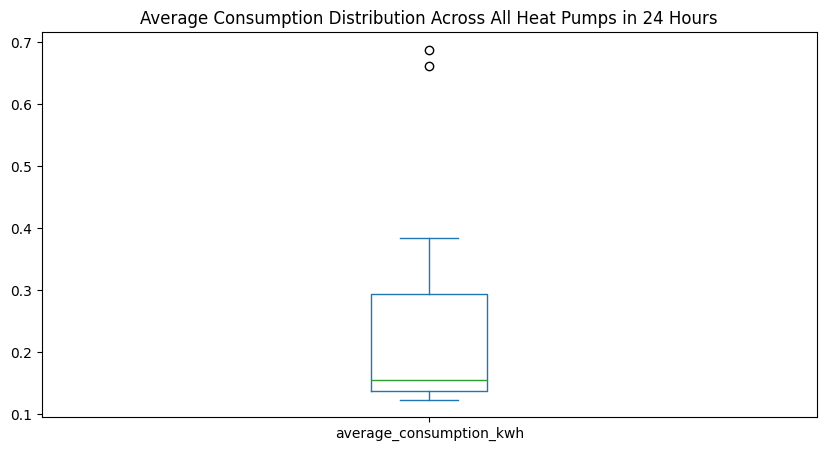

In [50]:
# Let's plot the distribution of the average consumption across all heat pumps in 24 hours
average_consumption_by_time['average_consumption_kwh'].plot(kind='box', figsize=(10, 5), title='Average Consumption Distribution Across All Heat Pumps in 24 Hours')

There are two outliers. Let's find out what causes them and if they are relevant or not.

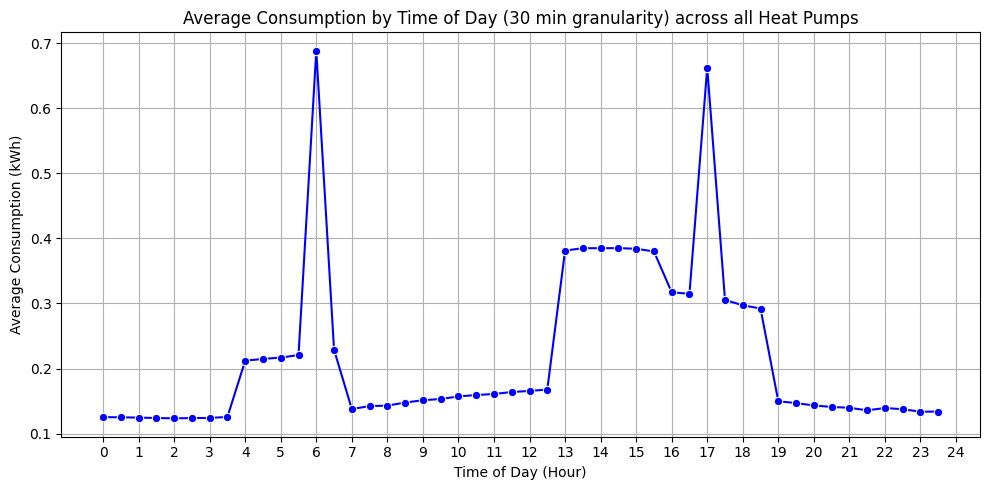

In [51]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=average_consumption_by_time,
    # Let's create a time variable by 0.5 hour granularity
    x=average_consumption_by_time['hour'] + average_consumption_by_time['minute'] / 60,
    y='average_consumption_kwh',
    marker='o',
    color='blue'
)
plt.title('Average Consumption by Time of Day (30 min granularity) across all Heat Pumps')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Average Consumption (kWh)')
plt.xticks(np.arange(0, 24.5, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Here we can see that the two outliers sits in specific time of the day and there may be a justification for that. 
Let's break down the plot and describe each time period:
1. **Night (00:00 - 03:30)**: Consumption is minimum, as expected, since heat pumps are not used as much during the night when people are sleeping.
2. **Early Morning (03:00 - 05:30)**: Consumption increases slightly to allow background heating needs to follow the set point, when people wake up and start their day.
3. **Morning (05:30 - 07:00)**: Consumption peaks around 6am presumably due to DHW storage tanks being filled up after the morning showers. 
4. **Day (07:00 - 12:30)**: Consumption drops significantly as people leave for work or school, and the heat pumps are not used as much but the average consumption tends to increase slightly to maintain consistent room temperature to the set point.
5. **Early Afternoon (12:30 - 13:00)**: Consumption increases as people return at home from part-time occupation or from school or for those who work from home.
6. **Afternoon (13:00 - 16:00)**: Consumption levels off, as people return home and require heating for their homes.
7. **Evening (16:00 - 18:30)**: Consumption peaks around 5pm again presumably due to DHW storage tanks being filled up after the evening showers.
8. **Night (18:30 - 23:59)**: Consumption drops again as people go to bed, and the heat pumps are not used as much during the night.

Let's verify how many properties have DHW storage tanks out of the total number of properties in the dataset.


In [52]:
property_df

,heat_pump_id,property_type,floor_area_m2,number_of_bedrooms,decade_built,insulation_level,has_hot_water_storage,location_id
0,1001,bungalow,98,2,2010,excellent,True,128
1,1002,terraced,81,2,1970,poor,True,127
2,1003,detached,188,3,2020,excellent,True,108
3,1004,flat,68,2,1970,poor,False,119
4,1005,bungalow,127,2,2020,good,True,109
5,1006,semi-detached,105,2,2000,average,True,101
6,1007,bungalow,110,3,1930,poor,True,110
7,1008,flat,44,1,1970,average,False,104
8,1009,semi-detached,148,3,2020,good,True,102
9,1010,terraced,108,3,1990,average,False,123


In [53]:
dhw_storage_tanks = property_df['has_hot_water_storage'].value_counts()
print(dhw_storage_tanks)

has_hot_water_storage
False    28
True     22
Name: count, dtype: int64


**Conclusion**:
Nearly 50% of the properties have DHW storage tanks, which is a significant portion of the dataset.
There is no reason to remove the outliers, as they are valid and reflect the expected consumption patterns of heat pumps throughout the day to allow background heating needs to follow the set point and to fill up the DHW storage tanks after the morning and evening showers.

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3.6 How does heat pump consumption vary across different homes?</p>

In [54]:
consumption_df

,interval_start,heat_pump_id,consumption_kwh
0,2024-01-01 00:00:00,1001,0.37
1,2024-01-01 00:00:00,1031,0.07
2,2024-01-01 00:00:00,1038,0.07
3,2024-01-01 00:00:00,1046,0.64
4,2024-01-01 00:00:00,1002,0.22
...,...,...,...
878395,2024-12-31 23:30:00,1033,0.93
878396,2024-12-31 23:30:00,1035,0.05
878397,2024-12-31 23:30:00,1034,0.06
878398,2024-12-31 23:30:00,1037,0.05


In [55]:
property_df

,heat_pump_id,property_type,floor_area_m2,number_of_bedrooms,decade_built,insulation_level,has_hot_water_storage,location_id
0,1001,bungalow,98,2,2010,excellent,True,128
1,1002,terraced,81,2,1970,poor,True,127
2,1003,detached,188,3,2020,excellent,True,108
3,1004,flat,68,2,1970,poor,False,119
4,1005,bungalow,127,2,2020,good,True,109
5,1006,semi-detached,105,2,2000,average,True,101
6,1007,bungalow,110,3,1930,poor,True,110
7,1008,flat,44,1,1970,average,False,104
8,1009,semi-detached,148,3,2020,good,True,102
9,1010,terraced,108,3,1990,average,False,123


In [56]:
# Let's merge consumption_df with property_df on 'heat_pump_id'
consumption_property_merged_df = pd.merge(consumption_df, property_df, on='heat_pump_id', how='left')
# Check the merged DataFrame
consumption_property_merged_df.head()

,interval_start,heat_pump_id,consumption_kwh,property_type,floor_area_m2,number_of_bedrooms,decade_built,insulation_level,has_hot_water_storage,location_id
0,2024-01-01,1001,0.37,bungalow,98,2,2010,excellent,True,128
1,2024-01-01,1031,0.07,terraced,109,3,2010,good,False,128
2,2024-01-01,1038,0.07,terraced,110,3,2010,excellent,False,128
3,2024-01-01,1046,0.64,detached,269,3,1950,poor,True,128
4,2024-01-01,1002,0.22,terraced,81,2,1970,poor,True,127


In [57]:
# Let's list the unique property_type 
consumption_property_merged_df['property_type'].unique()


array(['bungalow', 'terraced', 'detached', 'flat', 'semi-detached'],
      dtype=object)

In [58]:
# For each property type, let's calculate the average consumption per heat pump per 30-minute interval 
# across all heat pumps
average_consumption_by_property = consumption_property_merged_df.groupby(
    ['property_type', 'heat_pump_id', pd.Grouper(key='interval_start', freq='30min')]
)['consumption_kwh'].mean().reset_index()
# Calculate the average consumption across all heat pumps for each property type
average_consumption_by_property = average_consumption_by_property.groupby(
    ['property_type', 'interval_start']
)['consumption_kwh'].mean().reset_index()
# Rename the column for clarity
average_consumption_by_property.rename(columns={'consumption_kwh': 'average_consumption_kwh'}, inplace=True)
# Check the average consumption by property type
average_consumption_by_property.head()


,property_type,interval_start,average_consumption_kwh
0,bungalow,2024-01-01 00:00:00,0.15375
1,bungalow,2024-01-01 00:30:00,0.11750
2,bungalow,2024-01-01 01:00:00,0.12250
3,bungalow,2024-01-01 01:30:00,0.12125
4,bungalow,2024-01-01 02:00:00,0.12500


In [59]:
# Let's calculate the average consumption across all property types for each 30-minute interval in 24 hours
average_consumption_by_property_type = average_consumption_by_property.groupby(
    ['property_type', 'interval_start']
)['average_consumption_kwh'].mean().reset_index()
# Extract hour and minute for grouping later
average_consumption_by_property_type['hour'] = average_consumption_by_property_type['interval_start'].dt.hour
average_consumption_by_property_type['minute'] = average_consumption_by_property_type['interval_start'].dt.minute
# Calculate the average consumption across all property types for each 30-minute interval in 24 hours
average_consumption_by_time_property = average_consumption_by_property_type.groupby(
    ['hour', 'minute', 'property_type']
)['average_consumption_kwh'].mean().reset_index()
average_consumption_by_property

,property_type,interval_start,average_consumption_kwh
0,bungalow,2024-01-01 00:00:00,0.153750
1,bungalow,2024-01-01 00:30:00,0.117500
2,bungalow,2024-01-01 01:00:00,0.122500
3,bungalow,2024-01-01 01:30:00,0.121250
4,bungalow,2024-01-01 02:00:00,0.125000
...,...,...,...
87835,terraced,2024-12-31 21:30:00,0.137692
87836,terraced,2024-12-31 22:00:00,0.148462
87837,terraced,2024-12-31 22:30:00,0.133077
87838,terraced,2024-12-31 23:00:00,0.137692


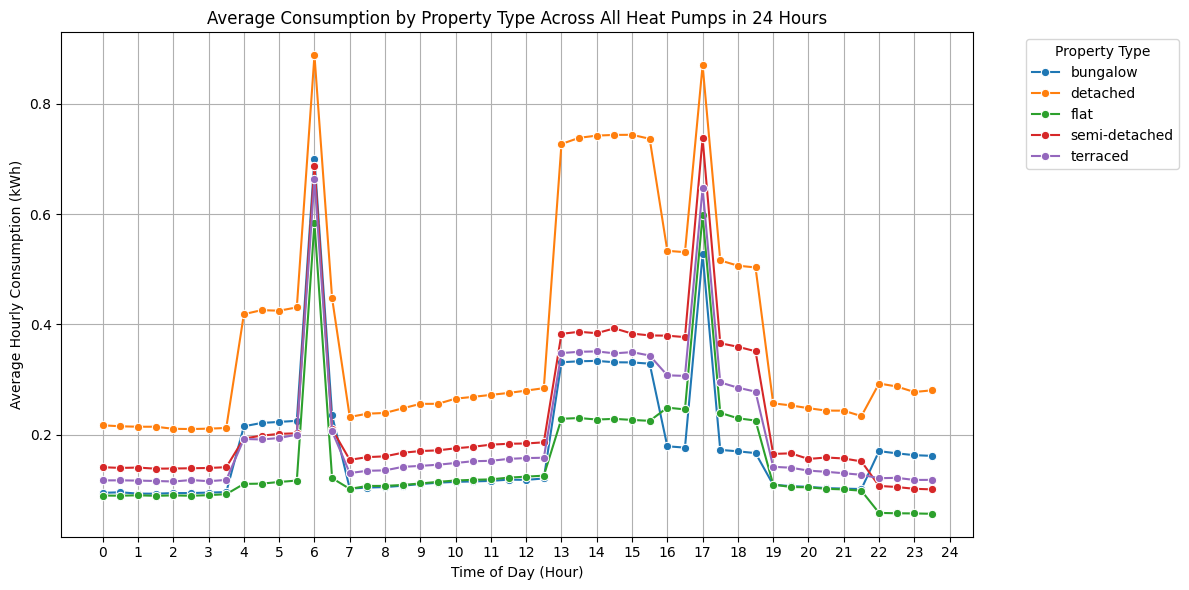

In [60]:

# Let's plot the average consumption by property type across all heat pumps in 24 hours
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=average_consumption_by_time_property,
    x=average_consumption_by_time_property['hour'] + average_consumption_by_time_property['minute'] / 60,
    y='average_consumption_kwh',
    hue='property_type',
    marker='o'
)
plt.title('Average Consumption by Property Type Across All Heat Pumps in 24 Hours')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Average Hourly Consumption (kWh)')
plt.xticks(np.arange(0, 24.5, 1))
plt.grid(True)
plt.legend(title='Property Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

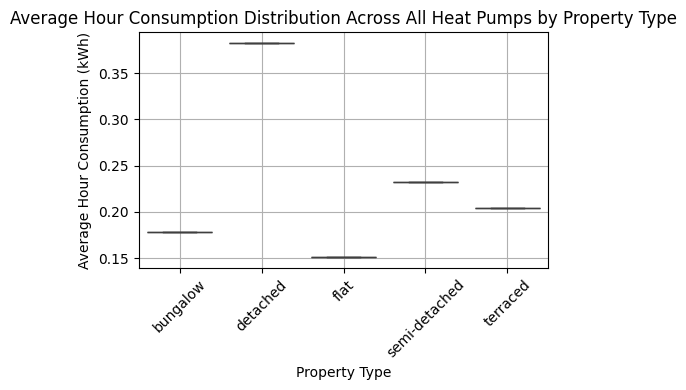

In [61]:
# Let's plot the distribution of the average consumption across 24 hours for each individual property type
average_consumption_by_time_property = average_consumption_by_time_property.groupby('property_type')['average_consumption_kwh'].mean().reset_index()
plt.figure(figsize=(5, 4))
sns.boxplot(
    data=average_consumption_by_time_property,
    x='property_type',
    y='average_consumption_kwh'
)
plt.title('Average Hour Consumption Distribution Across All Heat Pumps by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Hour Consumption (kWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusion:
All the properties type share a similar pattern of heat pump consumption throughout the day, with peaks in the morning and evening, and lower consumption during the night and early afternoon.
The heat pump consumption varies significantly across different homes, with some homes consuming much more than others.
This is due to the different types of properties, the number of occupants, and the different heating needs of each home.
Let's break it down by property type starting from the highest average heat pump consumption to the lowest:
1. **Detached House**: The average heat pump consumption for detached houses is around 0.38 kWh. This is the highest average consumption among all property types, likely due to the larger size of detached houses and potentially more occupants, leading to higher heating and domestic hot water (DHW) needs.
Also, detached houses are typically standalone properties, which may result in higher heat loss compared to other properties.
2. **Semi-Detached House**: The average heat pump consumption for semi-detached houses is around 0.23 kWh. Semi-detached houses usually share a party wall on one side and free-standing on the other. This can lead to lower heat loss compared to detached houses, resulting in lower heating and DHW needs. 
3. **Terraced House**: The average heat pump consumption for terraced houses is around 0.21 kWh. Terraced houses share walls with adjacent properties on both sides, which can help to retain heat and reduce heat loss, resulting in lower heating as well as lower DHW needs compared to detached and semi-detached houses.
4. **Bungalow**: The average heat pump consumption for bungalows is around 0.18 kWh. Similarly to detached houses, bungalows are standalone properties but single-story homes, which may have less heat loss compared to multi-story homes and less occupants, resulting in lower heating and DHW needs.
5. **Flat**: The average heat pump consumption for flats is around 0.15 kWh. Flats are typically smaller and have fewer occupants, resulting in lower heating and DHW needs. Also, a flat is generally within a building surrounded by other flats which helps to retain heat.

It's interesting to see the difference of Heat Pumps (HP) consumption between bungalows and detached houses, as they are both standalone properties but bungalows are single-story homes which may have less heat loss compared to multi-story homes and less occupants, resulting in lower heating and DHW needs. 
Bungalows consume on average 0.18 kWh, while detached houses consume on average 0.37 kWh, which is almost double the consumption of bungalows.
This suggests that the size, number of occupants and number of appliances served by DHW circuit in a property can have a significant impact on heat pump consumption.

To validate the above figures we can calculate the average daily heat pump consumption for a detached house which is 0.38 kWh * 24 hours = 9 kWh per day approximately.
This figure matches with the average daily consumption from Nesta: https://www.nesta.org.uk/report/what-homeowners-want-to-know-about-heat-pumps-data-driven-faqs/what-will-my-energy-costs-look-like-with-a-heat-pump/?utm_source=chatgpt.com 

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3.7 Are there any data quality issues (e.g. missing values, outliers)?</p>

Missing values are present in the consumption dataset, and have been handled by linear interpolation in section 3.1.

Outliers are present in the Average Consumption Distribution Across All Heat Pumps in 24 Hours, and have been handled in section 3.5.

Outliers have been detected in the overall consumption dataset in section 3.1 and have been verified in section 3.6 by looking at different type of buildings.

# <p style="padding:15px; background-color:grey; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">4. Feature Engineering</p>

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">4.1 Create Degree days (e.g. how cold it is relative to a base temperature)</p>

Heating Degree Days (HDD) help us figure out how much heating a building needs when it's cold outside. 

In the UK, the "base temperature" is set at 15.5°C (source: https://www.cibse.org/knowledge-research/knowledge-portal/technical-memorandum-41-degree-days-theory-and-application-2006-pdf/)

The base temperature is the outside temperature where a typical home doesn't need heating or cooling. 

If the outside temperature drops below that base, your heat pump kicks in to warm the home. The more it drops, the harder the heat pump has to work.

In [62]:
temperature_df

,interval_start,location_id,external_temperature_c
0,2024-01-01 00:00:00,101,3.10
1,2024-01-01 00:00:00,102,3.70
2,2024-01-01 00:00:00,103,5.46
3,2024-01-01 00:00:00,104,5.68
4,2024-01-01 00:00:00,105,3.79
...,...,...,...
527035,2024-12-31 23:30:00,126,4.07
527036,2024-12-31 23:30:00,127,4.87
527037,2024-12-31 23:30:00,128,7.40
527038,2024-12-31 23:30:00,129,6.26


In [63]:
# Let's crate a new column called Heating Degree Days (HDD) based on the external temperature 
# with a base temperature of 15.5°C

# Set the base temperature
base_temp_c = 15.5

# Calculate HDD for each row and add it as a new column
temperature_df['hdd'] = (base_temp_c - temperature_df['external_temperature_c']).clip(lower=0)

temperature_df.head()

,interval_start,location_id,external_temperature_c,hdd
0,2024-01-01,101,3.10,12.40
1,2024-01-01,102,3.70,11.80
2,2024-01-01,103,5.46,10.04
3,2024-01-01,104,5.68,9.82
4,2024-01-01,105,3.79,11.71


Let's calculate the Total Heating Demand over time

In [64]:
# Ensure interval_start is datetime
temperature_df['interval_start'] = pd.to_datetime(temperature_df['interval_start'])

# Set interval_start as the index
temperature_df.set_index('interval_start', inplace=True)
temperature_df.head()

,location_id,external_temperature_c,hdd
interval_start,,,
2024-01-01,101,3.10,12.40
2024-01-01,102,3.70,11.80
2024-01-01,103,5.46,10.04
2024-01-01,104,5.68,9.82
2024-01-01,105,3.79,11.71


In [ ]:
# Group by location and resample by month, summing HDD
monthly_hdd = (
    temperature_df
    .groupby('location_id')['hdd']
    .resample('ME') # 'ME' stands for month-end frequency
    .sum() # Sum HDD for each month
    .reset_index()
)

# Rename for clarity
monthly_hdd.rename(columns={'hdd': 'total_monthly_hdd'}, inplace=True)


print(monthly_hdd.head())


   location_id interval_start  total_monthly_hdd
0          101     2024-01-31           21532.01
1          101     2024-02-29           18085.02
2          101     2024-03-31           14646.69
3          101     2024-04-30            8290.30
4          101     2024-05-31            3315.25


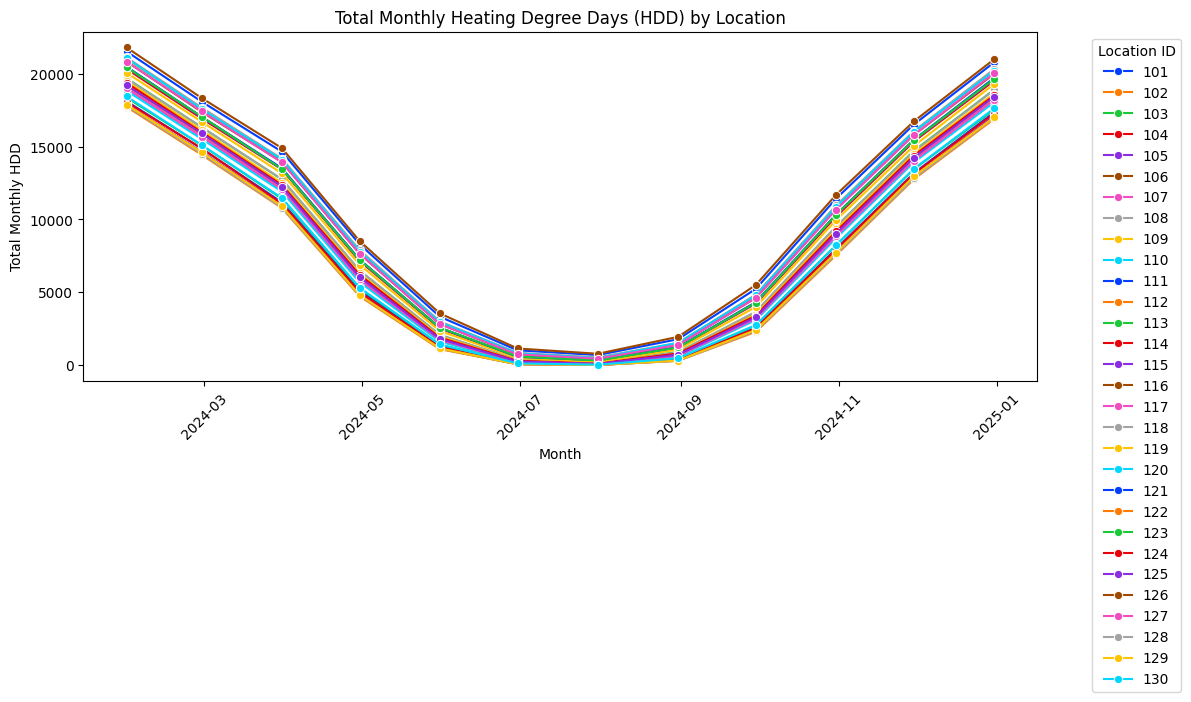

In [66]:
# Let's lineplot for each location_id
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_hdd,
    x='interval_start',
    y='total_monthly_hdd',
    hue='location_id',
    marker='o',
    palette='bright'
)
plt.title('Total Monthly Heating Degree Days (HDD) by Location')
plt.xlabel('Month')
plt.ylabel('Total Monthly HDD')
plt.xticks(rotation=45)
plt.legend(title='Location ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This plot shows how the total heating demand changes over time, with a clear seasonal pattern.
The total heating demand is highest in the winter months (December, January, February) and lowest in the summer months (June, July, August).
The total heating demand is calculated by summing the Heating Degree Days (HDD) for each day, which gives us an idea of how much heating is needed to maintain a comfortable temperature in the home.

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">4.2 Create Time-based features (hour of day, day of week, etc.)</p>

Time-based features are important for time series analysis, as they can help us capture the seasonal patterns and trends in the data.
Let's create some time-based features from the interval_start column in the heat pump consumption dataset.

In [67]:
consumption_df

,interval_start,heat_pump_id,consumption_kwh
0,2024-01-01 00:00:00,1001,0.37
1,2024-01-01 00:00:00,1031,0.07
2,2024-01-01 00:00:00,1038,0.07
3,2024-01-01 00:00:00,1046,0.64
4,2024-01-01 00:00:00,1002,0.22
...,...,...,...
878395,2024-12-31 23:30:00,1033,0.93
878396,2024-12-31 23:30:00,1035,0.05
878397,2024-12-31 23:30:00,1034,0.06
878398,2024-12-31 23:30:00,1037,0.05


In [68]:
# Let's create a new column for the year
consumption_df['year'] = consumption_df['interval_start'].dt.year

# Let's create a new column for the month
consumption_df['month'] = consumption_df['interval_start'].dt.month

# Let's create a new column for the day of the month
consumption_df['day_of_month'] = consumption_df['interval_start'].dt.day

# Let's create a new column for the hour
consumption_df['hour'] = consumption_df['interval_start'].dt.hour

# Let's create a new column for the minute
consumption_df['minute'] = consumption_df['interval_start'].dt.minute

# Let's create a new column for the day of the week as a number (1 = Monday, 7 = Sunday)
consumption_df['day_of_week'] = consumption_df['interval_start'].dt.dayofweek + 1

In [69]:
consumption_df

,interval_start,heat_pump_id,consumption_kwh,year,month,day_of_month,hour,minute,day_of_week
0,2024-01-01 00:00:00,1001,0.37,2024,1,1,0,0,1
1,2024-01-01 00:00:00,1031,0.07,2024,1,1,0,0,1
2,2024-01-01 00:00:00,1038,0.07,2024,1,1,0,0,1
3,2024-01-01 00:00:00,1046,0.64,2024,1,1,0,0,1
4,2024-01-01 00:00:00,1002,0.22,2024,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
878395,2024-12-31 23:30:00,1033,0.93,2024,12,31,23,30,2
878396,2024-12-31 23:30:00,1035,0.05,2024,12,31,23,30,2
878397,2024-12-31 23:30:00,1034,0.06,2024,12,31,23,30,2
878398,2024-12-31 23:30:00,1037,0.05,2024,12,31,23,30,2


To limit the number of features and capture the seasonal patterns in the dataset, let's integrate the sine and cosine features.
Converting timestamps into sine and cosine representations is beneficial when modeling time-based patterns because it captures the cyclical nature of time in a way that machine learning models can effectively learn from.

In [70]:
# Let's add the year-sine and year-cosine columns to the consumption_df
def year_sine(year):
    return np.sin(2 * np.pi * (year - 2020) / 10)  # Assuming the data spans 10 years from 2020
def year_cosine(year):
    return np.cos(2 * np.pi * (year - 2020) / 10)  # Assuming the data spans 10 years from 2020
consumption_df['year_sine'] = consumption_df['year'].apply(year_sine)
consumption_df['year_cosine'] = consumption_df['year'].apply(year_cosine)

# Let's add the month-sine and month-cosine columns to the consumption_df
def month_sine(month):
    return np.sin(2 * np.pi * month / 12)
def month_cosine(month):
    return np.cos(2 * np.pi * month / 12)
consumption_df['month_sine'] = consumption_df['month'].apply(month_sine)
consumption_df['month_cosine'] = consumption_df['month'].apply(month_cosine)

# Let's add the day-sine and day-cosine columns to the consumption_df
def day_sine(day_of_month):
    return np.sin(2 * np.pi * day_of_month / 31)
def day_cosine(day_of_month):
    return np.cos(2 * np.pi * day_of_month / 31)
consumption_df['day_sine'] = consumption_df['day_of_month'].apply(day_sine)
consumption_df['day_cosine'] = consumption_df['day_of_month'].apply(day_cosine)


# Let's add the hour-sine and hour-cosine columns to the consumption_df
def hour_sine(hour):
    return np.sin(2 * np.pi * hour / 24)
def hour_cosine(hour):
    return np.cos(2 * np.pi * hour / 24)
consumption_df['hour_sine'] = consumption_df['hour'].apply(hour_sine)
consumption_df['hour_cosine'] = consumption_df['hour'].apply(hour_cosine)

# Let's add the minute-sine and minute-cosine columns to the consumption_df
def minute_sine(minute):
    return np.sin(2 * np.pi * minute / 60)
def minute_cosine(minute):
    return np.cos(2 * np.pi * minute / 60)
consumption_df['minute_sine'] = consumption_df['minute'].apply(minute_sine)
consumption_df['minute_cosine'] = consumption_df['minute'].apply(minute_cosine) 

# Let's add the day-of-week-sine and day-of-week-cosine columns to the consumption_df
def day_of_week_sine(day_of_week):
    return np.sin(2 * np.pi * day_of_week / 7)
def day_of_week_cosine(day_of_week):
    return np.cos(2 * np.pi * day_of_week / 7)
consumption_df['day_of_week_sine'] = consumption_df['day_of_week'].apply(day_of_week_sine)
consumption_df['day_of_week_cosine'] = consumption_df['day_of_week'].apply(day_of_week_cosine)


In [71]:
consumption_df.head()

,interval_start,heat_pump_id,consumption_kwh,year,month,day_of_month,hour,minute,day_of_week,year_sine,...,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,minute_sine,minute_cosine,day_of_week_sine,day_of_week_cosine
0,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349
1,2024-01-01,1031,0.07,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349
2,2024-01-01,1038,0.07,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349
3,2024-01-01,1046,0.64,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349
4,2024-01-01,1002,0.22,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349


# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">4.3 Create Property-level characteristics</p>

In [72]:
property_df

,heat_pump_id,property_type,floor_area_m2,number_of_bedrooms,decade_built,insulation_level,has_hot_water_storage,location_id
0,1001,bungalow,98,2,2010,excellent,True,128
1,1002,terraced,81,2,1970,poor,True,127
2,1003,detached,188,3,2020,excellent,True,108
3,1004,flat,68,2,1970,poor,False,119
4,1005,bungalow,127,2,2020,good,True,109
5,1006,semi-detached,105,2,2000,average,True,101
6,1007,bungalow,110,3,1930,poor,True,110
7,1008,flat,44,1,1970,average,False,104
8,1009,semi-detached,148,3,2020,good,True,102
9,1010,terraced,108,3,1990,average,False,123


To perform forecasting we need to encode the property-level characteristics into numerical values. 

In [ ]:
# Let's encode categorical variables in the property DataFrame so boolean values 
# will replace classification values
property_df = pd.get_dummies(property_df, columns=['property_type', 'insulation_level'])

property_df.head()

,heat_pump_id,floor_area_m2,number_of_bedrooms,decade_built,has_hot_water_storage,location_id,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,1001,98,2,2010,True,128,True,False,False,False,False,False,True,False,False
1,1002,81,2,1970,True,127,False,False,False,False,True,False,False,False,True
2,1003,188,3,2020,True,108,False,True,False,False,False,False,True,False,False
3,1004,68,2,1970,False,119,False,False,True,False,False,False,False,False,True
4,1005,127,2,2020,True,109,True,False,False,False,False,False,False,True,False


# <p style="padding:15px; background-color:grey; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5. Forecasting</p>

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.1 Create the Dataframe for Forecasting </p>

In section 3.3 we have verified that the location_ids in property dataset are a subset of the location_id in temperature dataset.
To differentiate the location_ids in the temperature dataset, we will add a prefix to the location_id column in the temperature dataset.

In [74]:
# Let's rename the location_id in the property_df
property_df.rename(columns={'location_id': 'location_id_property'}, inplace=True)

# Let's rename the location_id in the temperature_df
temperature_df.rename(columns={'location_id': 'location_id_temperature'}, inplace=True)


In [75]:
consumption_df.head()

,interval_start,heat_pump_id,consumption_kwh,year,month,day_of_month,hour,minute,day_of_week,year_sine,...,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,minute_sine,minute_cosine,day_of_week_sine,day_of_week_cosine
0,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349
1,2024-01-01,1031,0.07,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349
2,2024-01-01,1038,0.07,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349
3,2024-01-01,1046,0.64,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349
4,2024-01-01,1002,0.22,2024,1,1,0,0,1,0.587785,...,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349


In [76]:
temperature_df.head()

,location_id_temperature,external_temperature_c,hdd
interval_start,,,
2024-01-01,101,3.10,12.40
2024-01-01,102,3.70,11.80
2024-01-01,103,5.46,10.04
2024-01-01,104,5.68,9.82
2024-01-01,105,3.79,11.71


In [77]:
property_df.head()

,heat_pump_id,floor_area_m2,number_of_bedrooms,decade_built,has_hot_water_storage,location_id_property,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,1001,98,2,2010,True,128,True,False,False,False,False,False,True,False,False
1,1002,81,2,1970,True,127,False,False,False,False,True,False,False,False,True
2,1003,188,3,2020,True,108,False,True,False,False,False,False,True,False,False
3,1004,68,2,1970,False,119,False,False,True,False,False,False,False,False,True
4,1005,127,2,2020,True,109,True,False,False,False,False,False,False,True,False


In [78]:
# Let's create a new dataframe that combines the consumption_df, temperature_df, and property_df
combined_df = pd.merge(consumption_df, temperature_df, on=['interval_start'], how='left')
combined_df.head()

,interval_start,heat_pump_id,consumption_kwh,year,month,day_of_month,hour,minute,day_of_week,year_sine,...,day_cosine,hour_sine,hour_cosine,minute_sine,minute_cosine,day_of_week_sine,day_of_week_cosine,location_id_temperature,external_temperature_c,hdd
0,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349,101,3.10,12.40
1,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349,102,3.70,11.80
2,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349,103,5.46,10.04
3,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349,104,5.68,9.82
4,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,0.97953,0.0,1.0,0.0,1.0,0.781831,0.62349,105,3.79,11.71


In [79]:

combined_df = pd.merge(combined_df, property_df, on='heat_pump_id', how='left')
combined_df.head()


,interval_start,heat_pump_id,consumption_kwh,year,month,day_of_month,hour,minute,day_of_week,year_sine,...,location_id_property,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,True,False,False,False,False,False,True,False,False
1,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,True,False,False,False,False,False,True,False,False
2,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,True,False,False,False,False,False,True,False,False
3,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,True,False,False,False,False,False,True,False,False
4,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,True,False,False,False,False,False,True,False,False


In [80]:
# Let's select only columns with dtype 'bool'
bool_like_columns = [
    col for col in combined_df.columns
    if combined_df[col].dropna().map(type).eq(bool).all()
]

# Let's convert Boolean vars to int
combined_df[bool_like_columns] = combined_df[bool_like_columns].astype(int)



In [81]:
combined_df.head()

,interval_start,heat_pump_id,consumption_kwh,year,month,day_of_month,hour,minute,day_of_week,year_sine,...,location_id_property,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,1,0,0,0,0,0,1,0,0
1,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,1,0,0,0,0,0,1,0,0
2,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,1,0,0,0,0,0,1,0,0
3,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,1,0,0,0,0,0,1,0,0
4,2024-01-01,1001,0.37,2024,1,1,0,0,1,0.587785,...,128,1,0,0,0,0,0,1,0,0


In [82]:
# Save the combined_df with timestamp to a CSV file
combined_df.to_csv('data/combined_with_timestamp_df.csv', index=False)

In [83]:
# Let's drop the 'interval_start' column as timestamps are not needed for modeling
combined_df.drop(columns=['interval_start'], inplace=True)

# Let's check the combined DataFrame
combined_df.head()


,heat_pump_id,consumption_kwh,year,month,day_of_month,hour,minute,day_of_week,year_sine,year_cosine,...,location_id_property,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,1001,0.37,2024,1,1,0,0,1,0.587785,-0.809017,...,128,1,0,0,0,0,0,1,0,0
1,1001,0.37,2024,1,1,0,0,1,0.587785,-0.809017,...,128,1,0,0,0,0,0,1,0,0
2,1001,0.37,2024,1,1,0,0,1,0.587785,-0.809017,...,128,1,0,0,0,0,0,1,0,0
3,1001,0.37,2024,1,1,0,0,1,0.587785,-0.809017,...,128,1,0,0,0,0,0,1,0,0
4,1001,0.37,2024,1,1,0,0,1,0.587785,-0.809017,...,128,1,0,0,0,0,0,1,0,0


In [84]:
# Save the combined_df without timestamp to a CSV file
combined_df.to_csv('data/combined_without_timestamp_df.csv', index=False)

In [85]:
# Let's drop time features (raw) and leave only sine and cosine features
time_features = [
    'year', 'month', 'day_of_month', 'hour', 'minute', 'day_of_week'
    ]
combined_df.drop(columns=time_features, inplace=True)
combined_df.head()

,heat_pump_id,consumption_kwh,year_sine,year_cosine,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,...,location_id_property,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,1001,0.37,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,128,1,0,0,0,0,0,1,0,0
1,1001,0.37,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,128,1,0,0,0,0,0,1,0,0
2,1001,0.37,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,128,1,0,0,0,0,0,1,0,0
3,1001,0.37,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,128,1,0,0,0,0,0,1,0,0
4,1001,0.37,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,128,1,0,0,0,0,0,1,0,0


In [86]:
# Save the combined_df without time features to a CSV file
combined_df.to_csv('data/combined_without_time_features_df.csv', index=False)

# <p style="padding:15px; background-color:orange; font-family:arial; font-weight:italic; color:white; font-size:40%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.1.1 Select the House</p>

For forecasting we will focus on a single property. By selecting a single home, we eliminate inter-home variability (like property size, bedroom quantity and insulation level), making it easier to isolate and understand the relationship between electricity consumption, time, and outdoor temperature.
Also, predicting demand for a single time series (home) allows us to focus on temporal modeling without needing to generalise across heterogeneous home types or insulation levels. 
The parameters chosen for selecting the property are as follows:

1. **Decade build**: 2020 — the most recent building in the dataset hence modern construction likely adheres to stricter building regulations.
2. **Has domestic hot water storage**: enables demand shifting and better aligns with the decarbonisation strategy.
3. **Property type**: detached - the highest average heat pump consumption among all property types, which is more representative of the typical usage patterns.
4. **Insulation level** excellent - better insulation leads to lower heat loss and more efficient heating.
5. **Number of bedrooms**: 3 - max number of bedroom for this combination also average-sized family, likely more typical usage patterns


In [87]:
# Define filter criteria
filtered_df = combined_df[
    (combined_df["number_of_bedrooms"] == 3) &
    (combined_df["decade_built"] == 2020) &
    (combined_df["has_hot_water_storage"] == True) &
    (combined_df["property_type_detached"] == True) &
    (combined_df["insulation_level_excellent"] == True)
    ]

# Extract unique heat_pump_ids from filtered_df
selected_ids = filtered_df["heat_pump_id"].unique().tolist()
print("Selected heat_pump_id(s):", selected_ids)

Selected heat_pump_id(s): [1003]


In [88]:
# Let's filter out all of the properties except for property with heat_pump_id 1003
filtered_combined_df = combined_df[combined_df['heat_pump_id'] == 1003]
# Let's check the filtered DataFrame
filtered_combined_df.head()  

,heat_pump_id,consumption_kwh,year_sine,year_cosine,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,...,location_id_property,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
180,1003,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,108,0,1,0,0,0,0,1,0,0
181,1003,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,108,0,1,0,0,0,0,1,0,0
182,1003,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,108,0,1,0,0,0,0,1,0,0
183,1003,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,108,0,1,0,0,0,0,1,0,0
184,1003,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,...,108,0,1,0,0,0,0,1,0,0


In [89]:
# For the purpose of forecasting let's drop categorical features (IDs)
ids_features = [
    'heat_pump_id', 
    'location_id_temperature', 
    'location_id_property'
    ]
filtered_combined_df = filtered_combined_df.drop(columns=ids_features)
filtered_combined_df.head()

,consumption_kwh,year_sine,year_cosine,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,minute_sine,...,has_hot_water_storage,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
180,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
181,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
182,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
183,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
184,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0


In [90]:
# Save the data to a CSV file
filtered_combined_df.to_csv('data/before_normal_filtered_combined_df.csv', index=False)

# <p style="padding:15px; background-color:orange; font-family:arial; font-weight:italic; color:white; font-size:40%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.1.2 Normalise the features</p>

In [91]:
# Let's normalise the continuos variables.
# In section 3.1 and 3.2 we have identified that the distribution of the consumption and temperature
# data is not Gaussian, so we will use Min-Max scaler to normalise the data between [0, 1] rather than 
# StandardScaler.
# Sine and cosine features are already in the range of [-1, 1], so we will not normalise them.

# Identify continuous columns to normalize
continuous_columns = [
    'consumption_kwh', 
    'external_temperature_c', 
    'hdd',
    'floor_area_m2',
    'number_of_bedrooms',
    'decade_built'
]
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the continuous columns
filtered_combined_df[continuous_columns] = scaler.fit_transform(filtered_combined_df[continuous_columns])
# Let's check the combined DataFrame after normalisation
filtered_combined_df.head()

,consumption_kwh,year_sine,year_cosine,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,minute_sine,...,has_hot_water_storage,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
180,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
181,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
182,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
183,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
184,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0


In [92]:
# Save the data to a CSV file
filtered_combined_df.to_csv('data/normal_filtered_combined_df.csv', index=False)

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.1 Linear Regression</p>

Considering non-linear patterns of the energy consumption, such as peaks as well as valleys, as identified in section 3.5, a linear regression model is unlikely suitable for this dataset as it may underfit.
However, we can still use linear regression as a baseline model to compare with more complex models later on.


In [94]:
# Read the normalised filtered_combined_df from the CSV file
df = pd.read_csv('data/normal_filtered_combined_df.csv')

df.head()

,consumption_kwh,year_sine,year_cosine,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,minute_sine,...,has_hot_water_storage,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
1,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
2,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
3,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
4,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0


In [95]:
# Let's prepare features and target
X = df.drop('consumption_kwh', axis=1)
y = df['consumption_kwh']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Fit Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [96]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 0.02
RMSE: 0.03
R²: 0.2156


These figures tell us the following:


- Mean Absolute Error (MAE) is 0.02 kWh, which means that on average, the model's predictions are off by 0.02 kWh from the actual values.


- Root Mean Squared Error (RMSE) is 0.03 kWh, which means that the model's predictions are off by 0.03 kWh on average, but it penalizes larger errors more than MAE.

Both MAE and RMSE are relatively low, indicating that the model is performing well in terms of accuracy.


- However, R-squared (R2) is 0.21, which means that the model is capable of explaining only 21% of the variance in the heat pump consumption data.
This suggests that the model is not capturing the non-linear patterns in the data, such as peaks and valleys, as identified in section 3.5.
This is expected, as linear regression is a simple model that assumes a linear relationship between the input features and the target variable.


In [97]:
# Get feature importances (coefficients)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_,
    'abs_importance': np.abs(model.coef_)
}).sort_values(by='abs_importance', ascending=False)

print("Top Important Features for Linear Regression:")
print(importance_df[['feature', 'coefficient']].head(15))


Top Important Features for Linear Regression:
                   feature   coefficient
7              hour_cosine -1.164504e-02
12  external_temperature_c -1.152678e-02
6                hour_sine -1.044824e-02
3             month_cosine  7.207653e-03
2               month_sine  3.737913e-03
9            minute_cosine  2.666927e-03
4                 day_sine  7.145892e-04
13                     hdd -7.024390e-04
5               day_cosine  4.917690e-04
10        day_of_week_sine  8.895212e-05
11      day_of_week_cosine  3.700411e-05
8              minute_sine  1.062661e-17
0                year_sine  2.913721e-24
1              year_cosine  0.000000e+00
14           floor_area_m2  0.000000e+00


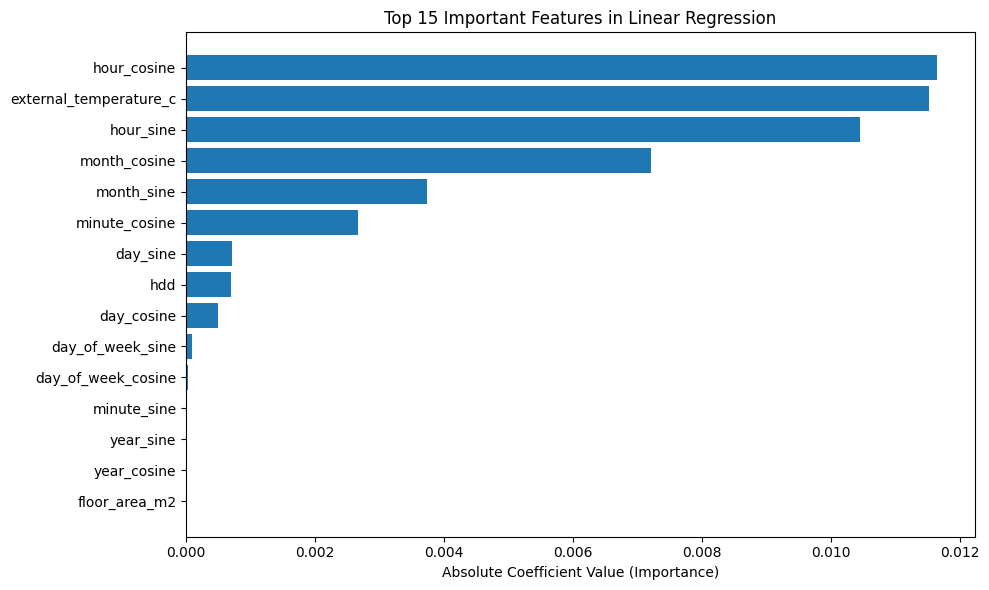

In [98]:
# Plot top N important features
top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['abs_importance'])
plt.gca().invert_yaxis()
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.title(f'Top {top_n} Important Features in Linear Regression')
plt.tight_layout()
plt.show()

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.2.1 Gradient Boosting Regressor - normal, with sine/cosine</p>

In [ ]:
# Load the filtered_combined_df from the CSV file
df = pd.read_csv('data/normal_filtered_combined_df.csv')
df.head()

,consumption_kwh,year_sine,year_cosine,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,minute_sine,...,has_hot_water_storage,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
1,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
2,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
3,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
4,0.032915,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0


In [100]:
X = df.drop(columns=['consumption_kwh'])  # features
y = df['consumption_kwh']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [101]:
# Let's train a Gradient Boosting Regressor model

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=69)
model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=69)

In [102]:
# Evaluate the model

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


MAE: 0.01
RMSE: 0.02
R²: 0.6000


These figures tell us the following:

- Mean Absolute Error (MAE) is 0.01 kWh, which means that on average, the model's predictions are off by 0.01 kWh from the actual values.


- Root Mean Squared Error (RMSE) is 0.02 kWh, which means that the model's predictions are off by 0.02 kWh on average, but it penalizes larger errors more than MAE.


Both MAE and RMSE are relatively low, indicating that the model is performing well in terms of accuracy.


- R-squared (R2) is 0.6, which means that the model is capable of explaining 60% of the variance in the heat pump consumption data.

This suggests that the model is not only close to the actual values, but is also capturing a meaningful amount of the underlying trend in the data.

In [103]:
# Let's optimise the Gradient Boosting Regressor model further using GridSearchCV to find 
# the best hyperparameters. The parameters grid will be limited to reasonable values and 
# avoid deeper trees to speed up the process and avoid overfitting.

param_grid = {
    'n_estimators': [100],              
    'learning_rate': [0.05, 0.1],       
    'max_depth': [3, 5],                
    'subsample': [0.8],                 
    'min_samples_split': [5]            
}

grid = GridSearchCV(
    GradientBoostingRegressor(random_state=69),
    param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best R²:", grid.best_score_)


Best R²: 0.681916718293726


That's a significant improvement over the linear regression model.

In [104]:

# Get feature importances
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top Important Features for Gradient Boosting Regressor:")
print(importance_df.head(15))

Top Important Features for Gradient Boosting Regressor:
                       feature  importance
6                    hour_sine    0.410497
7                  hour_cosine    0.339049
13                         hdd    0.056884
12      external_temperature_c    0.056394
8                  minute_sine    0.044757
9                minute_cosine    0.042161
3                 month_cosine    0.036486
2                   month_sine    0.006876
5                   day_cosine    0.004741
4                     day_sine    0.001282
11          day_of_week_cosine    0.000708
10            day_of_week_sine    0.000163
19      property_type_detached    0.000000
25       insulation_level_good    0.000000
24  insulation_level_excellent    0.000000


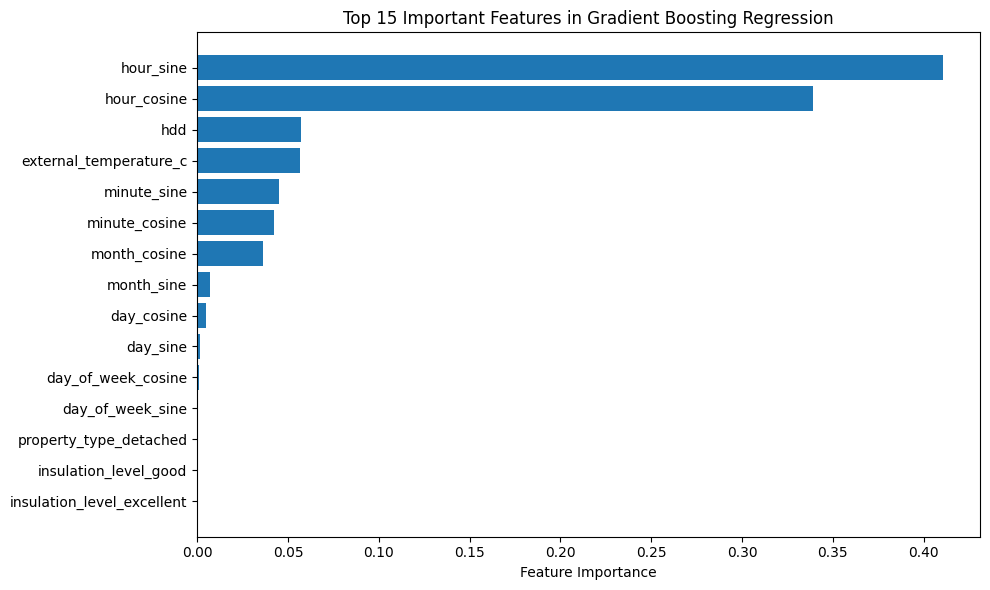

In [105]:
# Plot top N important features
top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Important Features in Gradient Boosting Regression')
plt.tight_layout()
plt.show()

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.2.2 Gradient Boosting Regressor - no normal, with sine/cosine</p>

In [125]:
# Load the filtered_combined_df from the CSV file
df = pd.read_csv('data/before_normal_filtered_combined_df.csv')
df.head()

,consumption_kwh,year_sine,year_cosine,month_sine,month_cosine,day_sine,day_cosine,hour_sine,hour_cosine,minute_sine,...,has_hot_water_storage,property_type_bungalow,property_type_detached,property_type_flat,property_type_semi-detached,property_type_terraced,insulation_level_average,insulation_level_excellent,insulation_level_good,insulation_level_poor
0,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
1,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
2,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
3,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0
4,0.21,0.587785,-0.809017,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.0,...,1,0,1,0,0,0,0,1,0,0


In [126]:
X = df.drop(columns=['consumption_kwh'])  # features
y = df['consumption_kwh']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [127]:
# Let's train a Gradient Boosting Regressor model

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=69)
model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=69)

In [128]:
# Evaluate the model

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


MAE: 0.05
RMSE: 0.12
R²: 0.6000


# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.3.1 XGBoosting for Regressor - no normalisation - with sine/cosine</p>

In [136]:
# Load dataset
df = pd.read_csv("data/before_normal_filtered_combined_df.csv")

# Define features and target
X = df.drop(columns=["consumption_kwh"])
y = df["consumption_kwh"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Train XGBoost regressor
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=69,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [137]:

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


Model Evaluation:
MAE:  0.0440
RMSE: 0.1039
R²:   0.7283


Top 10 Important Features:
hour_cosine               0.277212
hour_sine                 0.178565
minute_sine               0.148553
hdd                       0.095012
minute_cosine             0.074993
external_temperature_c    0.063338
month_cosine              0.054456
month_sine                0.027055
day_of_week_cosine        0.024004
day_sine                  0.023379
dtype: float32


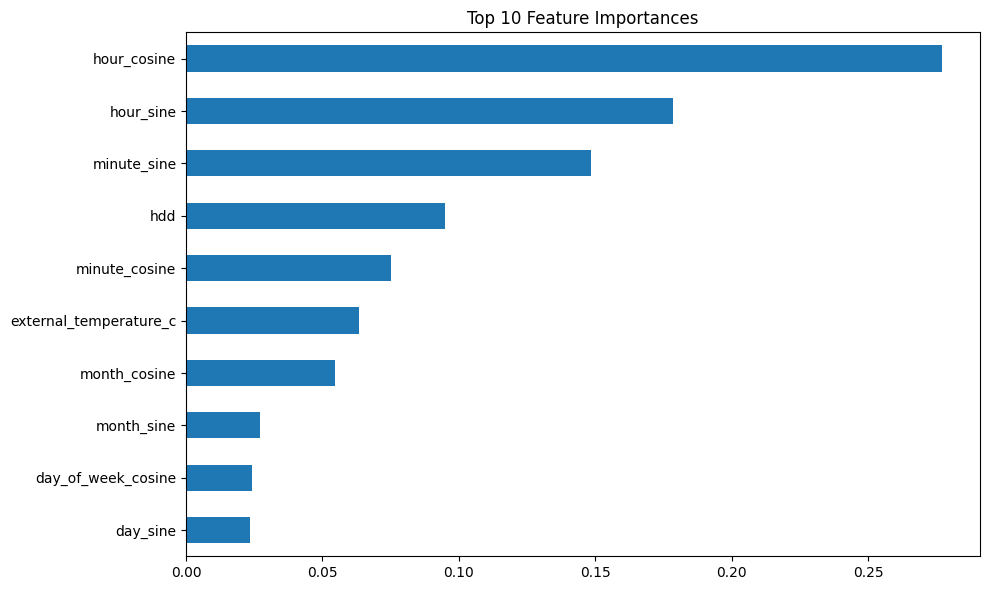

In [138]:

# Feature importance
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Important Features:")
print(importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
importance.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.3.2 XGBoosting for Regressor - normalisation - with sine/cosine</p>

In [133]:
# Load dataset
df = pd.read_csv("data/normal_filtered_combined_df.csv")

# Define features and target
X = df.drop(columns=["consumption_kwh"])
y = df["consumption_kwh"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Train XGBoost regressor
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=69,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [134]:

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


Model Evaluation:
MAE:  0.0069
RMSE: 0.0163
R²:   0.7283



🔍 Top 10 Important Features:
hour_cosine               0.277115
hour_sine                 0.178502
minute_sine               0.148501
hdd                       0.094979
minute_cosine             0.074967
external_temperature_c    0.063666
month_cosine              0.054437
month_sine                0.027046
day_of_week_cosine        0.023996
day_sine                  0.023371
dtype: float32


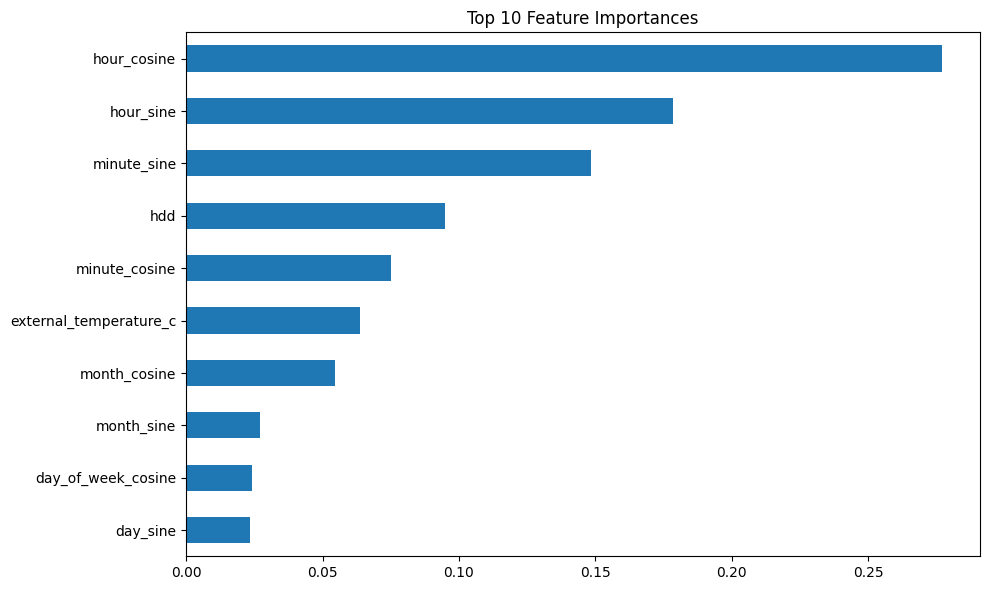

In [ ]:

# Feature importance
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🔍 Top 10 Important Features:")
print(importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
importance.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.3.3 XGBoosting - normalisation - with sine/cosine - train: Jan/Oct; train: Nov/Dec</p>

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:italic; color:white; font-size:50%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.4 Time Series - Long Short Term Memory (LSTM) Neural Network</p>

In [107]:
# Load data before normalisation
df = pd.read_csv("data/before_normal_filtered_combined_df.csv")

# Define target and feature columns
target_col = 'consumption_kwh'
feature_cols = df.columns[df.columns != target_col]

# Identify sine/cosine columns
sin_cos_cols = [col for col in feature_cols if 'sine' in col or 'cosine' in col]
to_scale_cols = [col for col in feature_cols if col not in sin_cos_cols]

# Normalize only non-sine/cosine features
scaler = MinMaxScaler()
scaled_part = scaler.fit_transform(df[to_scale_cols])

# Combine scaled features with sine/cosine values (unchanged)
combined_features = np.hstack([scaled_part, df[sin_cos_cols].values])

# Prepare data for LSTM
sequence_length = 48  # 24 hours of 30-minute intervals
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(combined_features[i:i + sequence_length])
    y.append(df[target_col].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)

# Train/test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(sequence_length, X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test).flatten()

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

/Users/luca/Documents/01_Scripting/octopus/octopus-venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 64s 19ms/step - loss: 0.0195 - val_loss: 0.0238
Epoch 2/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 62s 19ms/step - loss: 0.0137 - val_loss: 0.0254
Epoch 3/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 64s 19ms/step - loss: 0.0127 - val_loss: 0.0230
Epoch 4/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 63s 19ms/step - loss: 0.0124 - val_loss: 0.0252
Epoch 5/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 62s 19ms/step - loss: 0.0111 - val_loss: 0.0240
Epoch 6/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 63s 19ms/step - loss: 0.0114 - val_loss: 0.0263
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
MAE: 0.0571
RMSE: 0.1518
R²: 0.5234


# <p style="padding:15px; background-color:orange; font-family:arial; font-weight:italic; color:white; font-size:40%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.3.1 Pruning features with Random Forest</p>

In [108]:
# Load data
df = pd.read_csv("data/before_normal_filtered_combined_df.csv")

# Define target and features
target_col = 'consumption_kwh'
feature_cols = df.columns[df.columns != target_col]


In [109]:
# Let's estimate feature importance using Random Forest
X_rf = df[feature_cols]
y_rf = df[target_col]

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_rf, y_rf)

# Rank features
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Keep top N features (you can adjust N)
N = 10
top_features = feature_importance_df['feature'].head(N).tolist()
print("Top Features for Random Forest:")
print(top_features)

Top Features for Random Forest:
['hour_sine', 'hour_cosine', 'day_sine', 'day_cosine', 'hdd', 'minute_sine', 'day_of_week_sine', 'minute_cosine', 'day_of_week_cosine', 'external_temperature_c']


In [110]:

# Split into sine/cosine (not scaled) and others (to scale)
sin_cos_cols = [f for f in top_features if 'sine' in f or 'cosine' in f]
to_scale_cols = [f for f in top_features if f not in sin_cos_cols]

# Scale non-sin/cos features and combine
scaler = MinMaxScaler()
scaled_part = scaler.fit_transform(df[to_scale_cols])
combined_features = np.hstack([scaled_part, df[sin_cos_cols].values])


In [111]:

# Create sequences with a length of 48 (24 hours of 30-minute intervals)
sequence_length = 48
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(combined_features[i:i + sequence_length])
    y.append(df[target_col].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)

# Train/test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build and train LSTM
model = Sequential([
    LSTM(64, input_shape=(sequence_length, X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Top features used:", top_features)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

/Users/luca/Documents/01_Scripting/octopus/octopus-venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - loss: 0.0196 - val_loss: 0.0229
Epoch 2/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - loss: 0.0153 - val_loss: 0.0226
Epoch 3/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - loss: 0.0148 - val_loss: 0.0233
Epoch 4/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - loss: 0.0143 - val_loss: 0.0242
Epoch 5/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - loss: 0.0132 - val_loss: 0.0259
Epoch 6/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - loss: 0.0119 - val_loss: 0.0264
Epoch 7/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - loss: 0.0109 - val_loss: 0.0263
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Top features used: ['hour_sine', 'hour_cosine', 'day_sine', 'day_cosine', 'hdd', 'minute_sine', 'day_of_week_sine', 'minute_cosine', 'day_of_week_cosine', 'external_temperature_c']
MAE: 0.0568
RMSE: 0.1504
R²: 0.5319


# <p style="padding:15px; background-color:orange; font-family:arial; font-weight:italic; color:white; font-size:40%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">5.3.2 Dimensionality Reduction with PCA</p>

In [112]:
# Load dataset
df = pd.read_csv("data/before_normal_filtered_combined_df.csv")


In [113]:

# Define target and features
target_col = 'consumption_kwh'
feature_cols = df.columns[df.columns != target_col]

# Split features into sine/cosine (not scaled) and others (to scale)
sin_cos_cols = [col for col in feature_cols if 'sine' in col or 'cosine' in col]
to_scale_cols = [col for col in feature_cols if col not in sin_cos_cols]

# Scale non-sine/cosine features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[to_scale_cols])


In [114]:

# Apply PCA
n_pca_components = 5
pca = PCA(n_components=n_pca_components)
pca_features = pca.fit_transform(scaled_features)

# Combine PCA features with raw sine/cosine features
combined_features = np.hstack([pca_features, df[sin_cos_cols].values])


In [115]:

# Prepare LSTM sequences
sequence_length = 48
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(combined_features[i:i + sequence_length])
    y.append(df[target_col].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)

# Train/test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(sequence_length, X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


/Users/luca/Documents/01_Scripting/octopus/octopus-venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 0.0189 - val_loss: 0.0242
Epoch 2/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - loss: 0.0145 - val_loss: 0.0251
Epoch 3/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - loss: 0.0128 - val_loss: 0.0257
Epoch 4/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 0.0113 - val_loss: 0.0257
Epoch 5/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - loss: 0.0099 - val_loss: 0.0269
Epoch 6/10
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 0.0094 - val_loss: 0.0270


In [116]:

# Evaluate
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"PCA components used: {n_pca_components}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

3294/3294 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
PCA components used: 5
MAE: 0.0639
RMSE: 0.1555
R²: 0.4996


# <p style="padding:15px; background-color:grey; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">6. Evaluate and Interpret</p>

The model that performs best in terms of accuracy is the Gradient Boosting Regressor, with an R-squared value of 0.68 after optimisation with GridSearchCV, which means that it is capable of explaining 68% of the variance in the heat pump consumption data.


The LSTM model is also performing well, with an R-squared value of 0.5.


The Linear Regression model is the worst performing model, with an R-squared value of 0.21.

If we want to focus on the Gradient Boosting Regressor (after GridSearchCV) here are example of further dataset to add to improve the model:

1. Add More Historical Data: Include further years of half-hourly data. This helps the model learn seasonal trends (e.g., winter vs summer usage).

2. Create New Features from time such as 'Is it a weekend?' or 'Is it a holiday?'. This may help as the model learns from spikes in usage on weekends or holidays.


4. Include Weather Data: this can help the model understand how outdoor conditions affect heat pump usage (e.g., humidity, weather forecast).

5. Once more data points are added, more advanced models will be required: Consider using XGBoost or LightGBM, which often outperform standard Gradient Boosting model.

The 6 most important features from the Gradient Boosting Regressor:

- houre_sine
- Hour_cosine
- HDD (Heating Degree Days)
- outdoor_temperature
- minute_sine
- minute_cosine


This suggests that the model has learned that time of day and outside temperature are the main drivers of heat pump energy use. It relies on cyclical time features (sine, cosine) to capture daily and sub-hourly usage patterns, and on temperature-based indicators like HDD and outdoor_temperature to reflect demand due to weather.

# End of the notebook.